<a href="https://colab.research.google.com/github/AnIsAsPe/Aprendizaje-no-supervisado/blob/main/Knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knn algoritmo supervisado de clasificación

## 0. Cargar Bibliotecas

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler  #estandarizar varibles
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

from google.colab import files  #funcion para subir archivo csv a google colab

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Subir archivos de datos

files.upload()

## Leer datos 

In [2]:
X = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/Aprendizaje-no-supervisado/main/Datos/train_input_2yaM34J.csv',
                    index_col=['ID'])
X.drop('Date',axis=1, inplace=True)
X


,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,22.7,56.0,25.7,534.0,1.0
1,22.8,55.0,25.7,506.0,1.0
2,22.9,55.0,25.9,577.0,1.0
3,23.0,55.0,26.1,630.0,1.0
4,23.0,55.0,26.1,643.0,1.0
...,...,...,...,...,...
7995,20.5,26.0,18.4,390.0,5.0
7996,20.4,26.0,18.3,383.0,2.0
7997,20.3,26.0,18.2,377.0,1.0


In [3]:
Y = pd.read_csv('https://raw.githubusercontent.com/AnIsAsPe/Aprendizaje-no-supervisado/main/Datos/train_output_2kCtjpF.csv',
                    index_col=['ID'])
Y

,Score
ID,
0,4.0
1,4.0
2,4.0
3,2.0
4,3.0
...,...
7995,2.0
7996,2.0
7997,2.0


# Exploración y transformación de datos

In [4]:
Y.value_counts()

Score
3.0      3362
2.0      2181
4.0      1860
1.0       358
5.0       239
dtype: int64

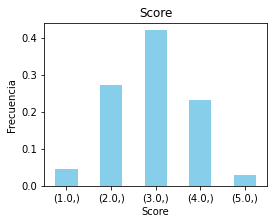

In [5]:
g = Y.value_counts(normalize=True).sort_index().plot(kind='bar',
                                       rot=0, 
                                       color='skyblue', figsize=(4,3))
g.set(ylabel='Frecuencia', title='Score')
plt.show()

In [6]:
datos = pd.concat([X, Y], axis=1)
datos.tail()

,Temperature,Humidity,Humex,CO2,Bright,Score
ID,,,,,,
7995,20.5,26.0,18.4,390.0,5.0,2.0
7996,20.4,26.0,18.3,383.0,2.0,2.0
7997,20.3,26.0,18.2,377.0,1.0,2.0
7998,20.2,26.0,18.0,385.0,1.0,2.0
7999,20.2,26.0,18.0,387.0,1.0,2.0


## Distribución univariada

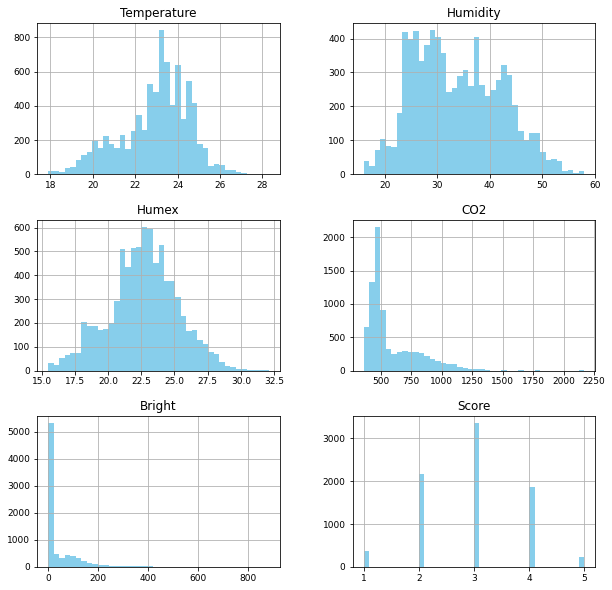

In [7]:
datos.hist(figsize = (10,10), xlabelsize=9, ylabelsize=9,
                               color='skyblue', bins= 40)
plt.show()

## Correlación entre variables

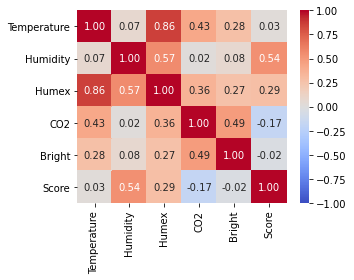

In [8]:
def correlacion(dataframe, grafica = True):
    corr=dataframe.corr()                #creamos la matriz de correlación
    fig = plt.figure(figsize = (5, 4))
    if grafica == True:
        sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, fmt=".2f", 
                    cmap="coolwarm", annot=True, square=False)
        fig.tight_layout()
    return corr
correlaciones = correlacion(datos)

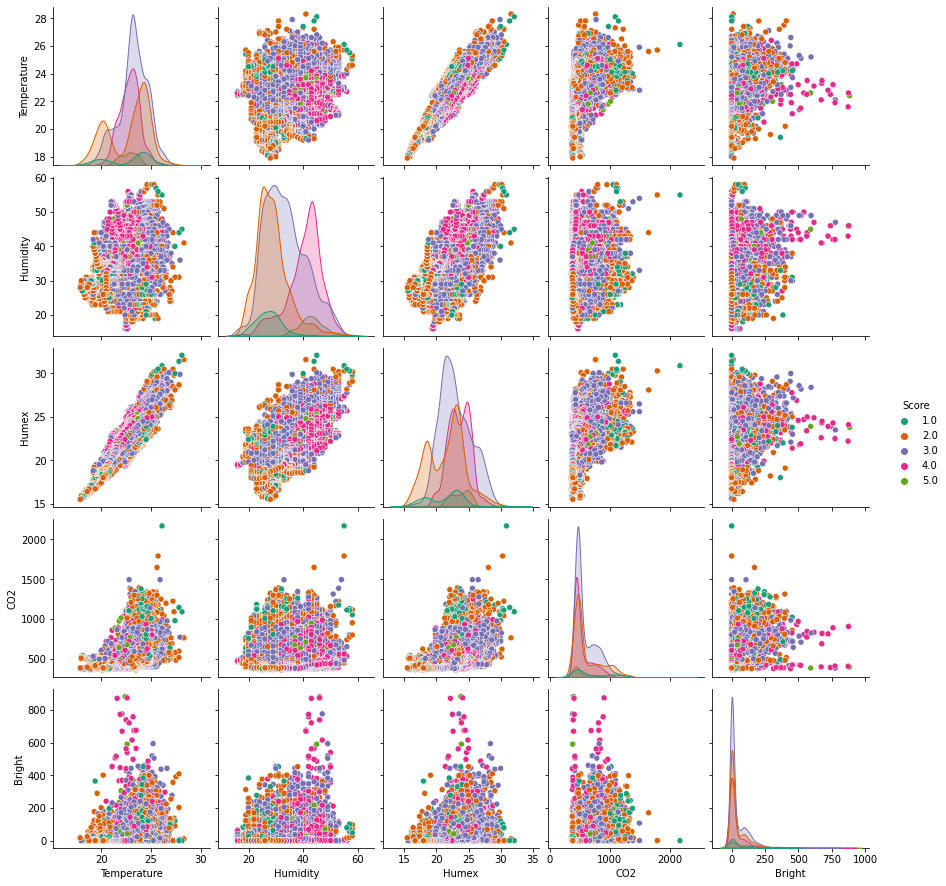

In [9]:
g = sns.pairplot(datos, palette ='Dark2', hue='Score')

plt.show()

## BoxPlot de mediciones según Score

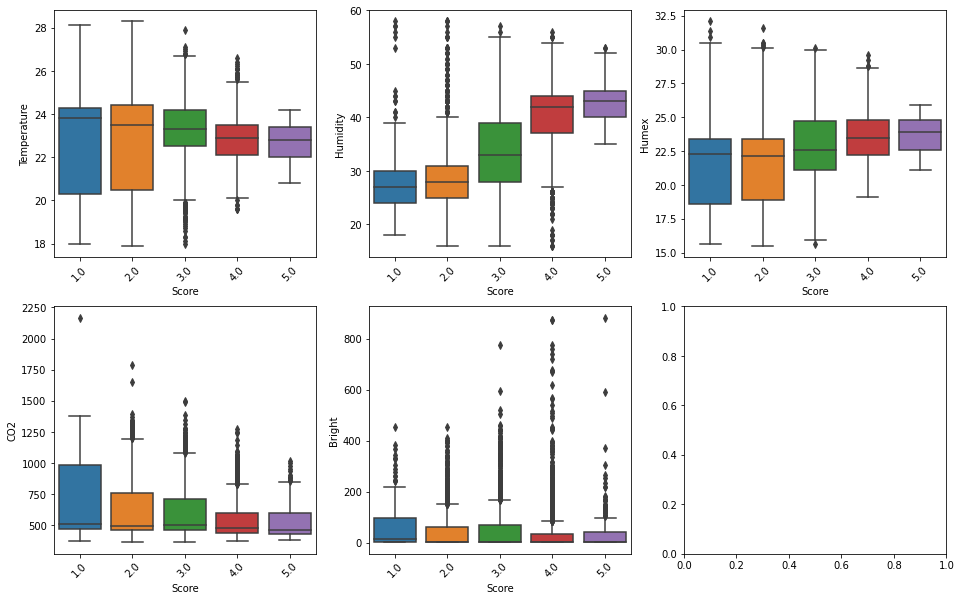

In [10]:
variables = datos.columns[:5]  #seleccionar columnas, excepto 'Score'
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
for var, subplot in zip(variables, ax.flatten()):
    sns.boxplot(x = 'Score', y = var, data = datos, ax=subplot, showfliers=True)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

In [39]:
datos['Score'] = datos['Score'].astype(str)

In [40]:
fig = px.scatter_3d(datos, x='Humidity', y='Bright', z='Temperature',
                    color='Score',
                    title="3D Scatter Plot")
fig.update_traces(marker=dict(size=3,),
                  selector=dict(mode='markers'))

fig.show()

## Unificar escalas de medición de cada variable

In [19]:
X_escalados = X.copy()
columnas = X.columns

escala = StandardScaler()

X_escalados[columnas] = escala.fit_transform(X[columnas])
X_escalados


,Temperature,Humidity,Humex,CO2,Bright
ID,,,,,
0,-0.151174,2.695116,1.175429,-0.258951,-0.528247
1,-0.089558,2.573765,1.175429,-0.397135,-0.528247
2,-0.027943,2.573765,1.252984,-0.046741,-0.528247
3,0.033673,2.573765,1.330538,0.214821,-0.528247
4,0.033673,2.573765,1.330538,0.278978,-0.528247
...,...,...,...,...,...
7995,-1.506714,-0.945416,-1.655307,-0.969610,-0.476198
7996,-1.568329,-0.945416,-1.694084,-1.004156,-0.515235
7997,-1.629945,-0.945416,-1.732861,-1.033767,-0.528247


# Knn

## Creación y exploración de subconjuntos de entrenamiento y prueba

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_escalados, Y,  
                                                    test_size=0.30, 
                                                    shuffle=True,
                                                    random_state=37)

Conjunto de entrenamiento
X:  (5600, 5)
Y:  (5600, 1)


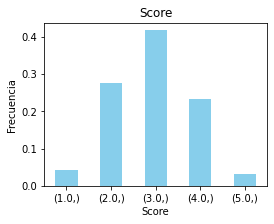

In [14]:
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("Y: ", y_train.shape)
g = y_train.value_counts(normalize=True).sort_index().plot(kind='bar',
                                                           rot=0, 
                                                           color='skyblue',
                                                           figsize=(4,3))
g.set(ylabel='Frecuencia', title='Score')
plt.show()

Conjunto de prueba
X:  (2400, 5)
Y:  (2400, 1)


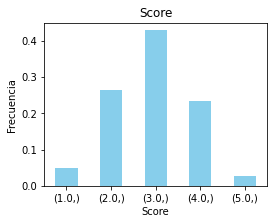

In [15]:
print("Conjunto de prueba")
print("X: ", X_test.shape)
print("Y: ", y_test.shape)
g = y_test.value_counts(normalize=True).sort_index().plot(kind='bar',
                                                           rot=0, 
                                                           color='skyblue',
                                                           figsize=(4,3))
g.set(ylabel='Frecuencia', title='Score')
plt.show()

## Entenamento del clasificador tomando en cuenta un solo vecino

In [29]:
modelo = KNeighborsClassifier(n_neighbors=5)
clasificador = modelo.fit(X_train, y_train['Score'])
y_pred = clasificador.predict(X_test)
print("Accuracy: %.2f%%" % (accuracy_score(y_test['Score'], y_pred)*100))


Accuracy: 67.33%


## Entenamento del clasificador tomando en cuenta cinco vecino

In [37]:
modelo = KNeighborsClassifier(n_neighbors=30)
clasificador = modelo.fit(X_train, y_train['Score'])
y_pred = clasificador.predict(X_test)
print("Accuracy: %.2f%%" % (accuracy_score(y_test['Score'], y_pred)*100))

Accuracy: 69.71%


In [31]:
modelo = KNeighborsClassifier(n_neighbors=5600)
clasificador = modelo.fit(X_train, y_train['Score'])
y_pred = clasificador.predict(X_test)
print("Accuracy: %.2f%%" % (accuracy_score(y_test['Score'], y_pred)*100))


Accuracy: 42.83%
